# Medical Appointment No Shows
Why do 30% of patients miss their scheduled appointments?

https://www.kaggle.com/joniarroba/noshowappointments#

**Author: Małgorzata Stolarska**

### Table of Contents

* [Data Dictionary](#data_dictionary)
* [Imports, parameters and initializations](#imports)
* [Data loading and initial checks](#loading)
* [Initial preprocessing](#preprocessing)
* [Split data set into training, validation and test parts](#split)
* [Data review on the training set](#data_review)
* [Data transformation](#data_transformation)
    * [Visualization of correlations](#visualization)
    * [Pipeline building](#pipeline)
* [Data transformation](#data_transformation)
* [Model building and evaluation](#models)
    * [Auxiliary classes and function](#classes)
    * [...](#...)
* [Final evaluation](#final)
* [Summary](#summary)

## Data Dictionary <a class="anchor" id="data_dictionary"></a>
- **PatientId**: Identification of a patient
- **AppointmentID**: Identification of each appointment
- **Gender**: 
Male or Female (female is the greater proportion, woman takes way more care of they health in comparison to man).
- **ScheduledDay**: 
The day of the actuall appointment, when they have to visit the doctor.
- **AppointmentDay**: 
The day someone called or registered the appointment, this is before appointment of course.
- **Age**: 
How old is the patient.
- **Neighbourhood**: 
Where the appointment takes place.
- **Scholarship**: True of False 
- **Hipertension**: True or False
- **Diabetes**: True or False
- **Alcoholism**: True or False
- **Handcap**: Number of disabilities (0 = a person without disability, 1 and more = a person with disabilities)
- **SMS_received**: Messages sent to the patient.
- **No-show (target variable)**: True or False.

## Imports, parameters and initializations <a class="anchor" id="imports"></a>

In [1]:
!python --version

Python 3.8.3


In [2]:
# !pip install --upgrade neptune-client 

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import __version__ as sklearn_version
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, make_scorer, f1_score, precision_score, recall_score
from sklearn.metrics import f1_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from keras import metrics
from datetime import time, date, datetime, timezone, timedelta

# freeze randomness:
from numpy.random import seed
from tensorflow.random import set_seed
seed(12) 
set_seed(123)

In [4]:
import neptune
# import neptune.new as neptun

# Token should be set in the system settings or directly below
PROJECT_NAME = "malgo.stolarska/Med-Appointments-No-Shows" 
# PROJECT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 
# run = neptune.init(project_qualified_name = PROJECT_NAME)
project = neptune.init(project_qualified_name = PROJECT_NAME)
project

Project(malgo.stolarska/Med-Appointments-No-Shows)

In [5]:
# Pandas options
pd.set_option('display.float_format', '{:.4f}'.format) 
pd.set_option('display.max_columns', None) 
pd.set_option("max_colwidth", None)

# Sklearn options 
from sklearn import set_config
set_config(display='diagram') # interactive diagrams for pipelines

In [6]:
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", sklearn_version)

pandas: 1.2.1
numpy: 1.19.5
sklearn: 0.24.2


In [7]:
path = "data"
author = "Małgorzata Stolarska"

## Data loading and initial checks <a class="anchor" id="loading"></a>

In [8]:
df = pd.read_csv(r'data/KaggleV2-May-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296.0000,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438.0000,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951.0000,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174.0000,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183.0000,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [9]:
df.shape

(110527, 14)

In [10]:
# Check duplicates
df.duplicated().sum()

0

In [11]:
# Check types
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [12]:
# Check target (ratio)
df["No-show"].value_counts(normalize=True, dropna=False)

No    0.7981
Yes   0.2019
Name: No-show, dtype: float64

## Initial preprocessing <a class="anchor" id="preprocessing"></a>

Assuming that the solution would be deployed in a production environment, I would be able to obtain data about the patient's history, such as the number of previous visits and the number of missed visits. I prepare such data below, i.e. for each appointment, I count data of previous appointments of the same patient.

The data don't include the time of appointments. In the case of a production solution, it should be added, but here I assume that sorting by AppointmentDay returns appointments in the correct orders.

In [13]:
def medicalAppointmentsDataPrepare(df, days_to_count=7):
    """
    Preparing Medical Appointments data
    """
    df_copy = df.copy()
        
    # Change types
    df_copy = df_copy.astype(dtype={"PatientId":"int64", \
                                    "ScheduledDay":"datetime64", \
                                    "AppointmentDay":"datetime64"})      
    
    # Change Yes/No to 1/0
    if set(df["No-show"].unique()) == {'No', 'Yes'}:
        df_copy["No-show"] = df_copy["No-show"].map({"Yes":1, "No":0}, na_action='ignore').astype("int64")  
    
    window = "".join([str(days_to_count), "D"])
    print("Window:", window)
     
    for idxs in df_copy.sort_values("AppointmentDay").groupby("PatientId").groups.values():          
        # Last successful visit and number of canceled visits since a last successful visit
        last_show = pd.Timestamp(0)
        last_noshow = pd.Timestamp(0)
        sumRecentNoShows = 0
        for i in idxs:
            df_copy.loc[i,"_lastShow"] = last_show
            df_copy.loc[i,"_lastNoShow"] = last_noshow
            df_copy.loc[i,"_sumRecentNoShows"] = sumRecentNoShows
            # the current visit cannot be included in the sum set for the current visit:
            if df_copy.loc[i,"No-show"] == 0:
                last_show = df_copy.loc[i,"AppointmentDay"]
                sumRecentNoShows = 0
            else:
                last_noshow = df_copy.loc[i,"AppointmentDay"]
                sumRecentNoShows += 1    

        # Number of canceled visits for a given patient in the last "days_to_count" days (without the current visit)
        rolled = df_copy.loc[idxs].rolling(window=window, on="AppointmentDay", min_periods=1, center=False, closed="left")
        df_copy.loc[idxs,"_sumAppoint_xD"] = rolled["No-show"].count().fillna(0)
        df_copy.loc[idxs,"_sumNoShows_xD"] = rolled["No-show"].sum().fillna(0)
    
    return df_copy   # .loc[days_to_count:] # we have no full data for the first "days_to_count" days

In [14]:
df = medicalAppointmentsDataPrepare(df)

Window: 7D


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   PatientId          110527 non-null  int64         
 1   AppointmentID      110527 non-null  int64         
 2   Gender             110527 non-null  object        
 3   ScheduledDay       110527 non-null  datetime64[ns]
 4   AppointmentDay     110527 non-null  datetime64[ns]
 5   Age                110527 non-null  int64         
 6   Neighbourhood      110527 non-null  object        
 7   Scholarship        110527 non-null  int64         
 8   Hipertension       110527 non-null  int64         
 9   Diabetes           110527 non-null  int64         
 10  Alcoholism         110527 non-null  int64         
 11  Handcap            110527 non-null  int64         
 12  SMS_received       110527 non-null  int64         
 13  No-show            110527 non-null  int64   

In [16]:
df[df["_sumNoShows_xD"]>0].sort_values("_sumNoShows_xD", ascending=False).head(100).tail(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
53738,65751443779385,5694590,M,2016-05-13 08:47:34,2016-05-13,14,ILHA DO PRÍNCIPE,0,0,0,0,0,0,1,1970-01-01,2016-05-13,5.0000,4.0000,4.0000
94274,17798942295934,5765372,F,2016-06-02 12:35:27,2016-06-07,39,ILHA DO PRÍNCIPE,0,0,0,0,0,1,0,2016-06-01,2016-06-06,4.0000,5.0000,4.0000
63917,56487939332227,5654677,F,2016-05-03 15:03:02,2016-05-19,63,ANDORINHAS,0,1,0,0,0,0,1,1970-01-01,2016-05-19,4.0000,4.0000,4.0000
70888,514249423598,5706847,M,2016-05-17 08:53:59,2016-05-17,23,MARIA ORTIZ,0,0,0,0,0,0,1,2016-05-11,2016-05-17,1.0000,5.0000,4.0000
55744,2728422248149,5617810,F,2016-04-25 17:17:46,2016-05-09,44,SÃO JOSÉ,0,0,0,0,0,0,1,2016-05-03,2016-05-06,3.0000,5.0000,4.0000


In [17]:
df[df["PatientId"]==2728422248149]\
         [["AppointmentDay","No-show","_lastShow","_lastNoShow","_sumRecentNoShows","_sumAppoint_xD","_sumNoShows_xD"]]\
         .sort_values("AppointmentDay")

,AppointmentDay,No-show,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
55896,2016-05-02,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
44617,2016-05-03,0,1970-01-01,2016-05-02,1.0000,1.0000,1.0000
25845,2016-05-06,1,2016-05-03,2016-05-02,0.0000,2.0000,1.0000
55927,2016-05-06,1,2016-05-03,2016-05-06,1.0000,3.0000,2.0000
59642,2016-05-06,1,2016-05-03,2016-05-06,2.0000,4.0000,3.0000
55744,2016-05-09,1,2016-05-03,2016-05-06,3.0000,5.0000,4.0000
71706,2016-05-12,0,2016-05-03,2016-05-09,4.0000,4.0000,4.0000
70983,2016-05-16,0,2016-05-12,2016-05-09,0.0000,2.0000,1.0000
29563,2016-05-18,0,2016-05-16,2016-05-09,0.0000,2.0000,0.0000
25831,2016-05-20,1,2016-05-18,2016-05-09,0.0000,2.0000,0.0000


#### [Save data]

In [18]:
# Dump data to pickle
with open("/".join([path, "prepared_NoShows.obj"]), "wb") as fp:
    pickle.dump(df, fp)

In [19]:
# Read data from pickle 
with open("/".join([path, "prepared_NoShows.obj"]), 'rb') as fp:
    df = pickle.load(fp)

## Split data set into training, validation and test parts <a class="anchor" id="split"></a>

In [20]:
# First, split patients:

# Choose unique patients
patients = pd.DataFrame(df["PatientId"].unique(), columns=["PatientId"])

# Split patients into training and test subsets
p_train, p_test = train_test_split(patients, test_size=0.3, random_state=33)

# Split patients from the test data into validation and test subsets
p_valid, p_test = train_test_split(p_test, test_size=0.5, random_state=33)

In [21]:
# Create training data
X_train = df.merge(p_train, on="PatientId", how="inner")
y_train = X_train["No-show"]
X_train.drop(columns="No-show", inplace=True)

In [22]:
# Create validation data
X_valid = df.merge(p_valid, on="PatientId", how="inner")
y_valid = X_valid["No-show"]
X_valid.drop(columns="No-show", inplace=True)

In [23]:
# Create test data
X_test = df.merge(p_test, on="PatientId", how="inner")
y_test = X_test["No-show"]
X_test.drop(columns="No-show", inplace=True)

In [24]:
# Shape od data sets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_valid.shape, y_valid.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (77212, 18) (77212,)
Validation set: (16536, 18) (16536,)
Test set: (16779, 18) (16779,)


In [25]:
y_train.value_counts(normalize=True, dropna=False)

0   0.7977
1   0.2023
Name: No-show, dtype: float64

In [26]:
y_valid.value_counts(normalize=True, dropna=False)

0   0.8006
1   0.1994
Name: No-show, dtype: float64

In [27]:
y_test.value_counts(normalize=True, dropna=False)

0   0.7971
1   0.2029
Name: No-show, dtype: float64

## Data review on the training set <a class="anchor" id="data_review"></a>

In [28]:
X_train.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
0,29872499824296,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
1,29872499824296,5639907,F,2016-04-29 09:47:47,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
2,558997776694438,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,2016-04-29,1970-01-01,0.0000,1.0000,0.0000
3,558997776694438,5642211,M,2016-04-29 15:20:47,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000
4,867951213174,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000


In [29]:
X_train.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD
count,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000,77212.0000
mean,146220554410208.2500,5675023.3771,37.1897,0.0959,0.1969,0.0714,0.0304,0.0230,0.3224,0.1146,0.4811,0.0812
std,254682375184094.2812,71629.5382,23.1154,0.2945,0.3977,0.2575,0.1718,0.1627,0.4674,0.4477,1.3470,0.3411
min,43741.0000,5122866.0000,-1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,4155717965492.2500,5640068.5000,18.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,31898380549723.0000,5680408.0000,37.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,94282577557931.0000,5725450.2500,56.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000
max,999981631772427.0000,5790484.0000,115.0000,1.0000,1.0000,1.0000,1.0000,4.0000,1.0000,17.0000,24.0000,8.0000


In [30]:
# Columns with NaN
with pd.option_context("display.max_rows", X_train.shape[1]):
    print(X_train.isna().any()[X_train.isna().any()])
    
# No NaNs in data

Series([], dtype: bool)


In [31]:
# Counted values in columns
for col in X_train.columns[2:]:
    print("Column:", col)
    with pd.option_context("display.max_rows", 20):
        print(X_train[col].value_counts(dropna=False))
    print("-" * 30)

Column: Gender
F    50152
M    27060
Name: Gender, dtype: int64
------------------------------
Column: ScheduledDay
2016-05-06 07:09:54    17
2016-05-06 07:09:53    17
2016-04-25 17:18:27    15
2016-04-25 17:17:46    15
2016-04-25 17:17:23    13
                       ..
2016-04-13 15:13:38     1
2016-03-31 08:22:37     1
2016-05-05 17:26:48     1
2016-05-17 11:39:25     1
2016-05-24 09:30:50     1
Name: ScheduledDay, Length: 73341, dtype: int64
------------------------------
Column: AppointmentDay
2016-06-06    3318
2016-05-30    3202
2016-05-09    3189
2016-05-16    3176
2016-05-11    3135
              ... 
2016-05-25    2741
2016-05-06    2671
2016-05-20    2665
2016-04-29    2280
2016-05-14      26
Name: AppointmentDay, Length: 27, dtype: int64
------------------------------
Column: Age
 0      2423
 1      1598
 52     1286
 38     1201
 56     1196
        ... 
 100       3
 102       2
 98        2
 115       1
-1         1
Name: Age, Length: 103, dtype: int64
-----------------

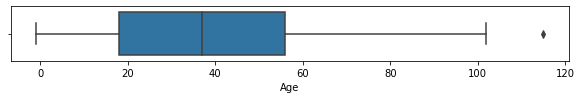

In [32]:
plt.figure(figsize=(10,1))
ax = sns.boxplot(x=X_train["Age"])
plt.show()

## Data transformation <a class="anchor" id="data_transformation"></a>

In [33]:
class MedicalAppointmentsTransformer(BaseEstimator, TransformerMixin):
    """
    Transformation of Medical Appointments data
    """
    
    def __init__(self, neighbourhood_min_count=200, max_time=30): 
        self.neighbourhood_min_count = neighbourhood_min_count
        self.max_time = max_time
        pass
            
    
    def fit(self, X, y=None):   
        X_y = X.join(y)
        
        # Neighbourhoods with numerous visits
        neighbourhoods_counts = X_y["Neighbourhood"].value_counts()
        self.neighbourhoods_ = neighbourhoods_counts[neighbourhoods_counts > self.neighbourhood_min_count]
        
        # Number of no-shows per day of week    
        X_y["_DayOfWeek"] = X_y["AppointmentDay"].dt.day_name()
        no_shows = X_y[X_y["No-show"] == 1].groupby(["_DayOfWeek"])["AppointmentID"].count()
        # Ratio of no-shows to all appointments on each day of week
        self.day_of_week_ratio_ = pd.DataFrame(no_shows/X_y.groupby(["_DayOfWeek"])["AppointmentID"].count()).\
                                               reset_index().rename(columns={"AppointmentID":"_DayOfWeekRatio"})      
        
        # Median of age
        self.age_median_ = X_y["Age"].median()
        
        return self

    
    def transform(self, X, y=None):
        X_copy = X.copy()   
        
        # Correct the age by taking the median
        X_copy.loc[X_copy["Age"] < 0, "_Age"] = self.age_median_
        X_copy.loc[X_copy["Age"] > 110, "_Age"] = self.age_median_
        
        # No-shows ratio in the last 7 days
        X_copy.loc[X_copy["_sumAppoint_xD"] > 0, "_NoShowsRatio_xD"] = X_copy["_sumNoShows_xD"] / X_copy["_sumAppoint_xD"]
        X_copy["_NoShowsRatio_xD"].fillna(0, inplace=True)
        
        # Change Gender F/M/others? to 1/0
        X_copy["_Gender"] = X_copy["Gender"]
        X_copy.loc[X_copy["_Gender"] == "M", "_Gender"] = "0"
        X_copy.loc[X_copy["_Gender"] != "0", "_Gender"] = "1"
        X_copy["_Gender"] = X_copy["_Gender"].astype("int64")
        
        # Change number of disabilies to flag: 0 = without disability, 1 = with disabilies
        X_copy["_Handcap"] = X_copy["Handcap"]
        # X_copy.loc[X_copy["_Handcap"] > 1, "_Handcap"] = 1
        
        # Combine small clinics into one (the model will not learn to predict for small classes)
        X_copy["_Neighbourhood"] = X_copy["Neighbourhood"].apply(lambda x: x if x in self.neighbourhoods_ else "OTHER")     
        
        # Ratio of no-shows to all appointments on each day of week (the column _DayOfWeekRatio will be added)    
        X_copy["_DayOfWeek"] = X_copy["AppointmentDay"].dt.day_name()
        X_copy = X_copy.merge(self.day_of_week_ratio_, on="_DayOfWeek", how="left").drop(columns="_DayOfWeek")
                                                 
        # Count waiting time
        X_copy["_WaitingTime"] = (X_copy["AppointmentDay"] - X_copy["ScheduledDay"]).dt.days.replace(to_replace=-1, value=0)
        
        # Count time from last successful visit  
        X_copy["_LastShowTime"] = (X_copy["AppointmentDay"] - X_copy["_lastShow"]).dt.days.replace(to_replace=-1, value=0)
        X_copy.loc[X_copy["_LastShowTime"] > self.max_time, "_LastShowTime"] = self.max_time
        
        # Count time from last no-show
        X_copy["_LastNoShowTime"] = (X_copy["AppointmentDay"] - X_copy["_lastNoShow"]).dt.days.replace(to_replace=-1, value=0)
        X_copy.loc[X_copy["_LastNoShowTime"] > self.max_time, "_LastNoShowTime"] = self.max_time
        
        return X_copy

In [34]:
# test (doesn't change X_train)
transformer = MedicalAppointmentsTransformer()
t = transformer.fit_transform(X_train, y_train)

In [35]:
t["_Handcap"].value_counts(dropna=False)

0    75579
1     1500
2      124
3        8
4        1
Name: _Handcap, dtype: int64

In [36]:
t["_Neighbourhood"].value_counts(dropna=False).head()

JARDIM CAMBURI     5495
MARIA ORTIZ        4145
RESISTÊNCIA        3121
JARDIM DA PENHA    2712
ITARARÉ            2481
Name: _Neighbourhood, dtype: int64

In [37]:
transformer.day_of_week_ratio_

,_DayOfWeek,_DayOfWeekRatio
0,Friday,0.2132
1,Monday,0.2079
2,Saturday,0.1923
3,Thursday,0.1964
4,Tuesday,0.2015
5,Wednesday,0.1940


In [38]:
t.sample(5, random_state=10)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood,_DayOfWeekRatio,_WaitingTime,_LastShowTime,_LastNoShowTime
36924,998759133161,5611528,M,2016-04-25 07:18:41,2016-05-30,59,TABUAZEIRO,0,1,0,0,0,1,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,NaN,0.0000,0,0,TABUAZEIRO,0.2079,34,30,30
71580,99517779642673,5755544,F,2016-06-01 07:28:00,2016-06-01,41,MARIA ORTIZ,0,0,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,NaN,0.0000,1,0,MARIA ORTIZ,0.1940,0,30,30
7870,456415184175233,5677108,F,2016-05-09 18:12:12,2016-05-19,19,JARDIM CAMBURI,0,0,0,0,0,0,2016-05-02,1970-01-01,0.0000,0.0000,0.0000,NaN,0.0000,1,0,JARDIM CAMBURI,0.1964,9,17,30
42594,96141862649212,5734546,F,2016-05-24 15:49:01,2016-05-25,13,SEGURANÇA DO LAR,0,0,0,0,0,0,2016-05-02,2016-05-02,0.0000,0.0000,0.0000,NaN,0.0000,1,0,OTHER,0.1940,0,23,23
42276,4778846566295,5654969,F,2016-05-03 15:38:12,2016-05-09,89,SÃO JOSÉ,0,1,0,0,0,0,1970-01-01,1970-01-01,0.0000,0.0000,0.0000,NaN,0.0000,1,0,SÃO JOSÉ,0.2079,5,30,30


In [39]:
t[t["_sumNoShows_xD"]>0].sort_values("_sumNoShows_xD", ascending=False).head(200).tail(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,_lastShow,_lastNoShow,_sumRecentNoShows,_sumAppoint_xD,_sumNoShows_xD,_Age,_NoShowsRatio_xD,_Gender,_Handcap,_Neighbourhood,_DayOfWeekRatio,_WaitingTime,_LastShowTime,_LastNoShowTime
45799,67332384894251,5676169,M,2016-05-09 15:07:28,2016-05-10,82,MONTE BELO,0,0,0,0,0,0,2016-05-03,2016-05-10,3.0000,5.0000,3.0000,NaN,0.6000,0,0,MONTE BELO,0.2015,0,7,0
16233,583462486114188,5674690,F,2016-05-09 11:42:16,2016-05-20,42,REDENÇÃO,0,0,0,0,0,0,2016-05-11,2016-05-20,3.0000,3.0000,3.0000,NaN,1.0000,1,0,REDENÇÃO,0.2132,10,9,0
29837,1952852324776,5665416,F,2016-05-05 14:24:17,2016-05-19,23,SÃO JOSÉ,0,0,0,0,0,0,2016-05-05,2016-05-13,3.0000,3.0000,3.0000,NaN,1.0000,1,0,SÃO JOSÉ,0.1964,13,14,6
75222,679765568947665,5627516,M,2016-04-27 09:35:44,2016-06-01,86,ROMÃO,0,1,0,0,0,0,1970-01-01,2016-06-01,3.0000,3.0000,3.0000,NaN,1.0000,0,0,ROMÃO,0.1940,34,30,0
45068,364521568338,5686851,M,2016-05-11 14:10:42,2016-05-18,9,TABUAZEIRO,1,0,0,0,0,0,2016-05-10,2016-05-17,3.0000,3.0000,3.0000,NaN,1.0000,0,0,TABUAZEIRO,0.1940,6,8,1


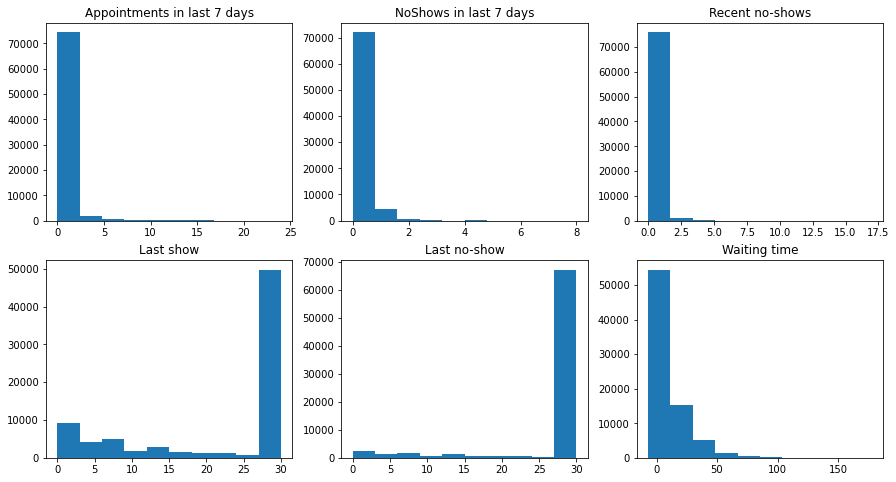

In [40]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs[0,0].hist(t['_sumAppoint_xD'])
axs[0,0].set_title('Appointments in last 7 days')
axs[0,1].hist(t['_sumNoShows_xD'])
axs[0,1].set_title('NoShows in last 7 days')
axs[0,2].hist(t['_sumRecentNoShows'])
axs[0,2].set_title('Recent no-shows')
axs[1,0].hist(t['_LastShowTime'])
axs[1,0].set_title('Last show')
axs[1,1].hist(t['_LastNoShowTime'])
axs[1,1].set_title('Last no-show')
axs[1,2].hist(t['_WaitingTime'])
axs[1,2].set_title('Waiting time')
plt.show()

In [41]:
print("Non-zero appointments in last 7 days:", df.loc[df['_sumAppoint_xD'] > 0, '_sumAppoint_xD'].count())
print("Non-zero no-shows in last 7 days:", df.loc[df['_sumNoShows_xD'] > 0, '_sumNoShows_xD'].count())
print("Non-zero no-shows since the last successful visit:", df.loc[df['_sumRecentNoShows'] > 0, '_sumRecentNoShows'].count())

Non-zero appointments in last 7 days: 29359
Non-zero no-shows in last 7 days: 7501
Non-zero no-shows since the last successful visit: 9815


### Visualization of correlations <a class="anchor" id="visualization"></a>

In [42]:
t_y = t.join(y_train)

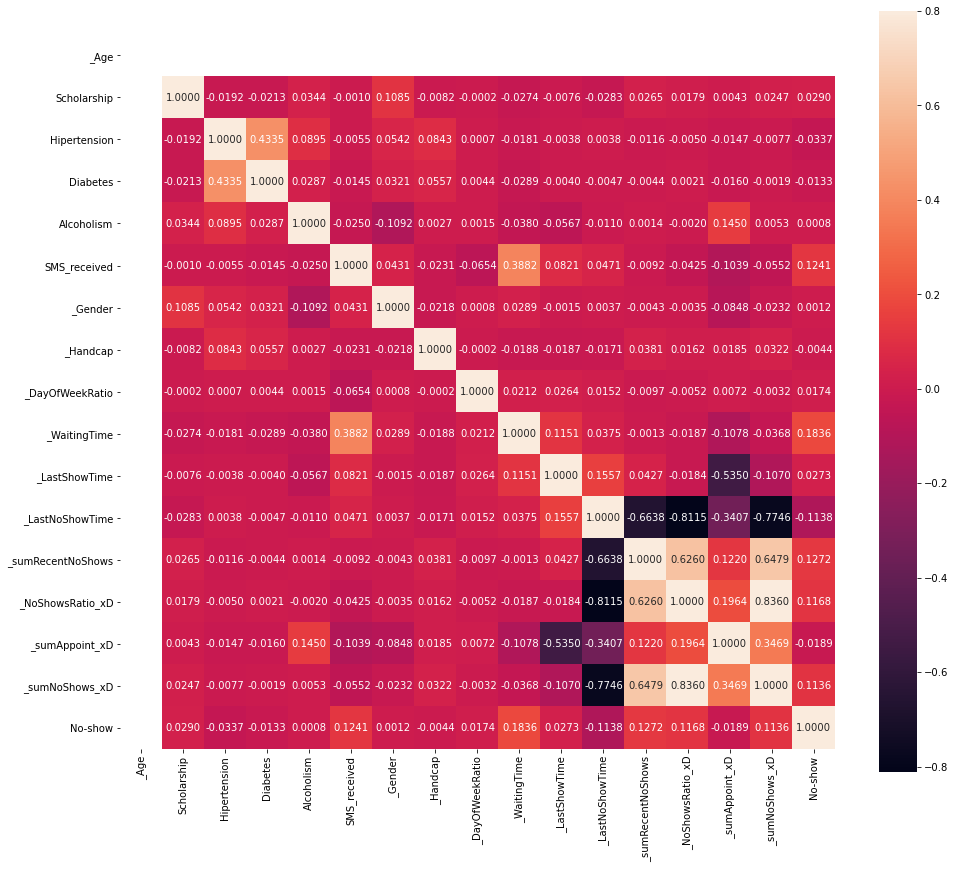

In [43]:
# Correlation matrix
cols = ["_Age","Scholarship","Hipertension","Diabetes","Alcoholism","SMS_received","_Gender","_Handcap",\
        "_DayOfWeekRatio","_WaitingTime","_LastShowTime","_LastNoShowTime","_sumRecentNoShows",\
        "_NoShowsRatio_xD","_sumAppoint_xD","_sumNoShows_xD","No-show"]
corr_matr = t_y[cols].corr()
f, ax = plt.subplots(figsize=(16,14))
sns.heatmap(corr_matr, annot=True, fmt='.4f', vmax=.8, square=True);

Columns _sumNoShows_xD and _LastNoShowTime will be removed, because they are strong correlated with _NoShowsRatio and have high correlation with _sumRecentNoShow.

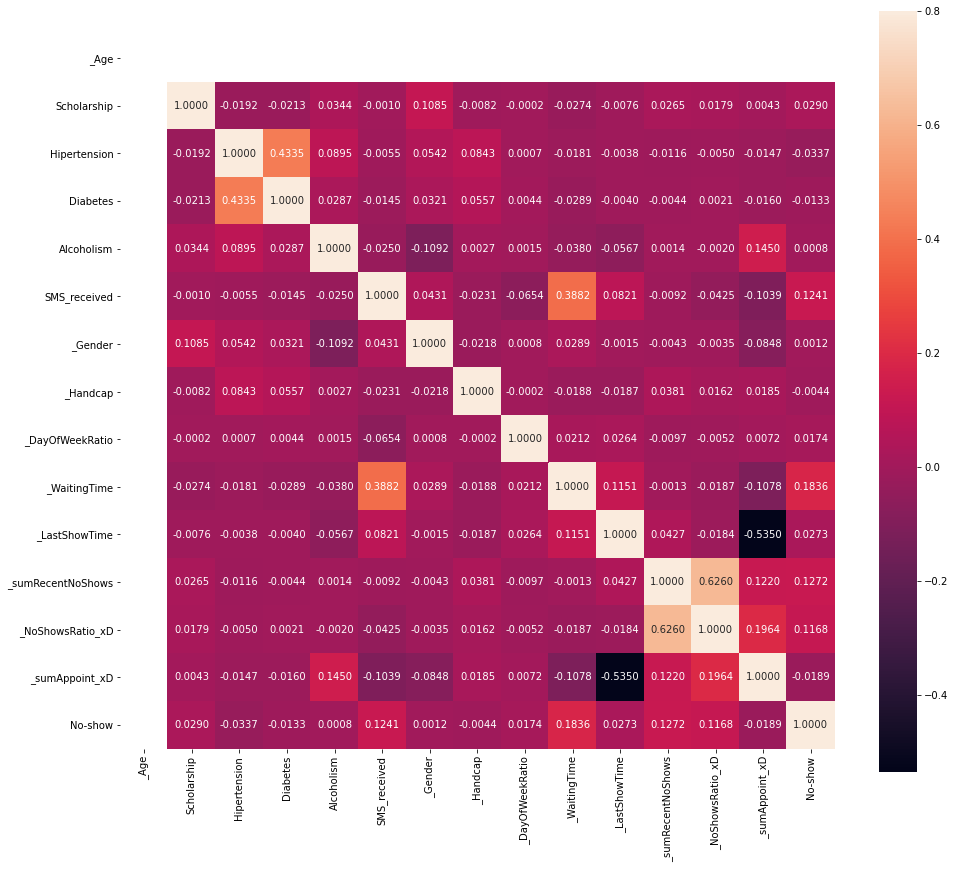

In [44]:
#Correlation matrix
cols = ["_Age","Scholarship","Hipertension","Diabetes","Alcoholism","SMS_received","_Gender","_Handcap",\
        "_DayOfWeekRatio","_WaitingTime","_LastShowTime","_sumRecentNoShows",\
        "_NoShowsRatio_xD","_sumAppoint_xD","No-show"]
corr_matr = t_y[cols].corr()
f, ax = plt.subplots(figsize=(16,14))
sns.heatmap(corr_matr, annot=True, fmt='.4f', vmax=.8, square=True);

#### No-shows over time

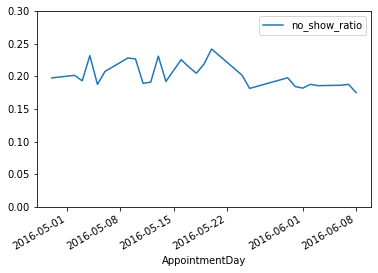

In [45]:
# Number of no-shows per day
no_shows_in_time = t_y[t_y["No-show"] == 1].groupby(["AppointmentDay"])["AppointmentID"].count()
# Ratio of no-shows to all appointments per day
no_shows_in_time = pd.DataFrame(no_shows_in_time/t_y.groupby(["AppointmentDay"])["AppointmentID"].count()).reset_index()
no_shows_in_time.rename(columns={"AppointmentID":"no_show_ratio"}, inplace=True)

no_shows_in_time.plot(x="AppointmentDay", ylim=(0,0.3))

I will skip over time analysis as the period is short and the fluctuations over time are likely to come from coincidences such as traffic jams and have no value for the prediction for future time periods.

### Pipeline building <a class="anchor" id="pipeline"></a>

In [46]:
class ColumnsRemover(BaseEstimator, TransformerMixin):
    """
    Transformer to drop specified columns
    """
    
    def __init__(self, columns_to_drop=[]):      
        # self.variable name has to have the same name like a parameter name
        self.columns_to_drop = columns_to_drop
        
            
    def fit(self, X, y=None):        
        return self
    

    def transform(self, X, y=None):
        # inplace=False for security reason, not to modify the varable X outside of the function
        return X.drop(self.columns_to_drop, axis=1, inplace=False)

In [47]:
class ColumnsSelectorByKind(BaseEstimator, TransformerMixin):
    """
    Transformer to select columns of specified kind:
    "num" = numerical but not binary, "bin" = binary (0/1), "cat" = categorical
    """
    
    def _get_columns_types(self):
        return ["int64", "float64"] if self.kind == "num" else ["int64"] if self.kind == "bin" else ["object"]
            
    
    def __init__(self, kind):
        # self.variable name has to have the same name like a parameter name
        self.kind = kind  
            
            
    def fit(self, X, y=None):            
        self.columns_to_select_ = list(X.columns[[c in self._get_columns_types() for c in X.dtypes.values]])
        if self.kind == "bin":
            self.columns_to_select_ = [c for c in self.columns_to_select_ if set(X[c].unique()) == set([0, 1])]
        elif self.kind == "num":
            self.columns_to_select_ = [c for c in self.columns_to_select_ if set(X[c].unique()) != set([0, 1])]
        return self
    

    def transform(self, X, y=None):
        return X[self.columns_to_select_]

In [48]:
# Pipeline for binary columns
bin_pipeline = make_pipeline(
    ColumnsSelectorByKind("bin"),
    SimpleImputer(strategy="most_frequent")
)

In [49]:
# Pipeline for numerical columns
num_pipeline = make_pipeline(
    ColumnsSelectorByKind("num"),
    SimpleImputer(strategy="median"),
    StandardScaler()
)

In [50]:
# Pipeline for categorical columns
cat_pipeline = make_pipeline(
    ColumnsSelectorByKind("cat"),
    SimpleImputer(strategy="constant", fill_value="OTHER"),
    OneHotEncoder(sparse=False, drop="first")
)

In [51]:
# Final transformer
columns_to_drop = ["PatientId", "AppointmentID", "ScheduledDay", "AppointmentDay", "Neighbourhood", "Handcap", "Age", "Gender",\
                   "_lastShow", "_lastNoShow", "_sumNoShows_xD", "_LastNoShowTime"]

custom_transformer = Pipeline([
    ("mat", MedicalAppointmentsTransformer(neighbourhood_min_count = 30)),
    ("rem", ColumnsRemover(columns_to_drop=columns_to_drop)),
    ("fun", FeatureUnion([
        ("bin_branch", bin_pipeline),
        ("num_branch", num_pipeline),
        ("cat_branch", cat_pipeline)
    ]))
])

In [52]:
# test (doesn't change X_train)
custom_transformer.fit_transform(X_train, y_train)

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Model building and evaluation <a class="anchor" id="models"></a>

### Auxiliary classes and functions <a class="anchor" id="classes"></a>

In [53]:
class ModelMetrics():
    """
    Calculate, print and save metrics
    """
        
    def __init__(self, y_true, y_pred):
        self.y = y_true
        self.y_pred = y_pred
        self.metrics_ = {}
        
        self.metrics_["accuracy"] = accuracy_score(y_true, y_pred)
        self.metrics_["f1"] = f1_score(y_true, y_pred)
        self.metrics_["recall"] = recall_score(y_true, y_pred)
        self.metrics_["precision"] = precision_score(y_true, y_pred)
        self.metrics_["ROC"] = roc_auc_score(y_true, y_pred)    

        
    def print_metrics(self, desc=None, with_header=True): 
        width_des, width_val = 14, 10
        format_lab = ["{:<"+str(width_des)+"}"] + ["{:>"+str(width_val)+"}"] * len(self.metrics_)
        format_val = ["{:<"+str(width_des)+"}"] + ["{:>"+str(width_val)+".2f}"] * len(self.metrics_)
        if with_header:            
            print(" | ".join(format_lab).format("", *self.metrics_.keys()))
            print("---".join(format_lab).format("-" * width_des, *["-" * width_val] * len(self.metrics_)))
        print(" | ".join(format_val).format(desc, *self.metrics_.values()))

In [54]:
def evaluate_model(model, save=True, tags=None):
    name = model.named_steps["model"].__class__.__name__
    print(name)
    if save:
        run = project.create_experiment(name=name)
        run.append_tags([author, name])
        if tags is not None: run.append_tags(tags)
        
    y_pred = model.predict(X_train)
    
    model_metrics = ModelMetrics(y_train, y_pred)
    model_metrics.print_metrics(desc="Training set", with_header=True)
    
    y_pred = model.predict(X_valid)
    
    model_metrics = ModelMetrics(y_valid, y_pred)
    model_metrics.print_metrics(desc="Validation set", with_header=False)
    
    fig, ax = plt.subplots(figsize=(3, 3))
    plot_confusion_matrix(model, X_valid, y_valid, cmap='Blues', ax=ax)
    plt.show()
    
    print("-" * 100)
    print("Classification report:")
    print(classification_report(y_valid, y_pred))
    
    # Metrics on validation data
    if save:
        for key, val in model_metrics.metrics_.items():
            run.log_metric(key, val)
    

### LogisticRegression

In [55]:
max_iter = 1000
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom_transformer", custom_transformer),
    ("model", LogisticRegression(max_iter=max_iter, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom_transformer__mat__neighbourhood_min_count = 500)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 Pipeline(steps=[('mat',
                                  MedicalAppointmentsTransformer(neighbourhood_min_count=500)),
                                 ('rem',
                                  ColumnsRemover(columns_to_drop=['PatientId',
                                                                  'AppointmentID',
                                                                  'ScheduledDay',
                                                                  'AppointmentDay',
                                                                  'Neighbourhood',
                                                                  'Handcap',
                                                                  'Age',
                                                                  'Gender',
                                                                  '_lastShow',
                                                                  '_lastNoShow',
                                                                  '_sumNoShows_xD',
                                                                  '_LastNoShowTime'])),
                                 ('fun',
                                  FeatureUnion(tran...
                                                                                  ('standardscaler',
                                                                                   StandardScaler())])),
                                                                 ('cat_branch',
                                                                  Pipeline(steps=[('columnsselectorbykind',
                                                                                   ColumnsSelectorByKind(kind='cat')),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(fill_value='OTHER',
                                                                                                 strategy='constant')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse=False))]))]))])),
                ('model',
                 LogisticRegression(class_weight={0: 1, 1: 4}, max_iter=1000,
                                    random_state=99))])

LogisticRegression


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://ui.neptune.ai/malgo.stolarska/Med-Appointments-No-Shows/e/MED-35
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |       0.66 |       0.41 |       0.59 |       0.32 |       0.64
Validation set |       0.65 |       0.40 |       0.58 |       0.31 |       0.63


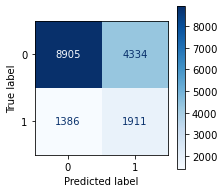

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.87      0.67      0.76     13239
           1       0.31      0.58      0.40      3297

    accuracy                           0.65     16536
   macro avg       0.59      0.63      0.58     16536
weighted avg       0.75      0.65      0.69     16536



In [56]:
evaluate_model(pipeline, tags=["neighbourhood_min_count = 500"])

In [57]:
max_iter = 1000
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom_transformer", custom_transformer),
    ("model", LogisticRegression(max_iter=max_iter, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom_transformer__mat__neighbourhood_min_count = 2)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 Pipeline(steps=[('mat',
                                  MedicalAppointmentsTransformer(neighbourhood_min_count=2)),
                                 ('rem',
                                  ColumnsRemover(columns_to_drop=['PatientId',
                                                                  'AppointmentID',
                                                                  'ScheduledDay',
                                                                  'AppointmentDay',
                                                                  'Neighbourhood',
                                                                  'Handcap',
                                                                  'Age',
                                                                  'Gender',
                                                                  '_lastShow',
                                                                  '_lastNoShow',
                                                                  '_sumNoShows_xD',
                                                                  '_LastNoShowTime'])),
                                 ('fun',
                                  FeatureUnion(transf...
                                                                                  ('standardscaler',
                                                                                   StandardScaler())])),
                                                                 ('cat_branch',
                                                                  Pipeline(steps=[('columnsselectorbykind',
                                                                                   ColumnsSelectorByKind(kind='cat')),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(fill_value='OTHER',
                                                                                                 strategy='constant')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse=False))]))]))])),
                ('model',
                 LogisticRegression(class_weight={0: 1, 1: 4}, max_iter=1000,
                                    random_state=99))])

LogisticRegression
https://ui.neptune.ai/malgo.stolarska/Med-Appointments-No-Shows/e/MED-36
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |       0.66 |       0.42 |       0.60 |       0.32 |       0.64
Validation set |       0.65 |       0.40 |       0.58 |       0.30 |       0.62


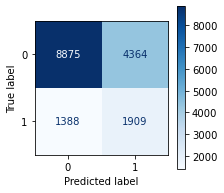

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.86      0.67      0.76     13239
           1       0.30      0.58      0.40      3297

    accuracy                           0.65     16536
   macro avg       0.58      0.62      0.58     16536
weighted avg       0.75      0.65      0.68     16536



In [58]:
evaluate_model(pipeline, tags=["neighbourhood_min_count = 2"])

### Decision Tree Classifier

In [59]:
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom_transformer", custom_transformer),
    ("model", DecisionTreeClassifier(max_depth=12, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom_transformer__mat__neighbourhood_min_count = 500)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 Pipeline(steps=[('mat',
                                  MedicalAppointmentsTransformer(neighbourhood_min_count=500)),
                                 ('rem',
                                  ColumnsRemover(columns_to_drop=['PatientId',
                                                                  'AppointmentID',
                                                                  'ScheduledDay',
                                                                  'AppointmentDay',
                                                                  'Neighbourhood',
                                                                  'Handcap',
                                                                  'Age',
                                                                  'Gender',
                                                                  '_lastShow',
                                                                  '_lastNoShow',
                                                                  '_sumNoShows_xD',
                                                                  '_LastNoShowTime'])),
                                 ('fun',
                                  FeatureUnion(tran...
                                                                                  ('standardscaler',
                                                                                   StandardScaler())])),
                                                                 ('cat_branch',
                                                                  Pipeline(steps=[('columnsselectorbykind',
                                                                                   ColumnsSelectorByKind(kind='cat')),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(fill_value='OTHER',
                                                                                                 strategy='constant')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse=False))]))]))])),
                ('model',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 4}, max_depth=12,
                                        random_state=99))])

DecisionTreeClassifier
https://ui.neptune.ai/malgo.stolarska/Med-Appointments-No-Shows/e/MED-37
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |       0.61 |       0.47 |       0.84 |       0.32 |       0.70
Validation set |       0.60 |       0.44 |       0.79 |       0.30 |       0.67


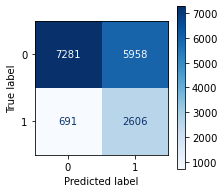

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.55      0.69     13239
           1       0.30      0.79      0.44      3297

    accuracy                           0.60     16536
   macro avg       0.61      0.67      0.56     16536
weighted avg       0.79      0.60      0.64     16536



In [60]:
evaluate_model(pipeline, tags=["neighbourhood_min_count = 500"])

In [61]:
class_weight = {0:1, 1:4} 

pipeline = Pipeline([
    ("custom_transformer", custom_transformer),
    ("model", DecisionTreeClassifier(max_depth=12, class_weight=class_weight, random_state=99))
])
pipeline.set_params(custom_transformer__mat__neighbourhood_min_count = 2)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 Pipeline(steps=[('mat',
                                  MedicalAppointmentsTransformer(neighbourhood_min_count=2)),
                                 ('rem',
                                  ColumnsRemover(columns_to_drop=['PatientId',
                                                                  'AppointmentID',
                                                                  'ScheduledDay',
                                                                  'AppointmentDay',
                                                                  'Neighbourhood',
                                                                  'Handcap',
                                                                  'Age',
                                                                  'Gender',
                                                                  '_lastShow',
                                                                  '_lastNoShow',
                                                                  '_sumNoShows_xD',
                                                                  '_LastNoShowTime'])),
                                 ('fun',
                                  FeatureUnion(transf...
                                                                                  ('standardscaler',
                                                                                   StandardScaler())])),
                                                                 ('cat_branch',
                                                                  Pipeline(steps=[('columnsselectorbykind',
                                                                                   ColumnsSelectorByKind(kind='cat')),
                                                                                  ('simpleimputer',
                                                                                   SimpleImputer(fill_value='OTHER',
                                                                                                 strategy='constant')),
                                                                                  ('onehotencoder',
                                                                                   OneHotEncoder(drop='first',
                                                                                                 sparse=False))]))]))])),
                ('model',
                 DecisionTreeClassifier(class_weight={0: 1, 1: 4}, max_depth=12,
                                        random_state=99))])

DecisionTreeClassifier
https://ui.neptune.ai/malgo.stolarska/Med-Appointments-No-Shows/e/MED-38
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |       0.61 |       0.47 |       0.86 |       0.32 |       0.70
Validation set |       0.59 |       0.43 |       0.80 |       0.30 |       0.67


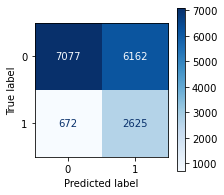

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67     13239
           1       0.30      0.80      0.43      3297

    accuracy                           0.59     16536
   macro avg       0.61      0.67      0.55     16536
weighted avg       0.79      0.59      0.63     16536



In [62]:
evaluate_model(pipeline, tags=["neighbourhood_min_count = 2"])

### XGBoost Classifier

In [66]:
pipeline = Pipeline([
    ("custom_transformer", custom_transformer),
    ("model", XGBClassifier(booster="gbtree", random_state=99))
])

In [73]:
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

grid = GridSearchCV(pipeline,
                    scoring = ["f1_score"],
                    param_grid={"model__eta": [0.2, 0.3, 0.8],
                                "model__max_depth": [6, 9, 12],
                                "custom_transformer__mat__neighbourhood_min_count": [100, 500]}, 
                    cv=kfold, refit=False, n_jobs=4)

grid.fit(X_train, y_train)
print("The best parameter:\r\n", grid.best_params_)  

The best parameter:
 {'custom_transformer__mat__neighbourhood_min_count': 100, 'model__eta': 0.2, 'model__max_depth': 6}


C:\Users\malgo\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [69]:
pipeline.set_params(model__eta = 0.2)
pipeline.set_params(model__max_depth = 6)
pipeline.set_params(custom_transformer__mat__neighbourhood_min_count = 500)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('custom_transformer',
                 Pipeline(steps=[('mat',
                                  MedicalAppointmentsTransformer(neighbourhood_min_count=500)),
                                 ('rem',
                                  ColumnsRemover(columns_to_drop=['PatientId',
                                                                  'AppointmentID',
                                                                  'ScheduledDay',
                                                                  'AppointmentDay',
                                                                  'Neighbourhood',
                                                                  'Handcap',
                                                                  'Age',
                                                                  'Gender',
                                                                  '_lastShow',
                                                                  '_lastNoShow',
                                                                  '_sumNoShows_xD',
                                                                  '_LastNoShowTime'])),
                                 ('fun',
                                  FeatureUnion(tran...
                               colsample_bytree=1, eta=0.2, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.200000003, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, random_state=99,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

XGBClassifier
https://ui.neptune.ai/malgo.stolarska/Med-Appointments-No-Shows/e/MED-39
               |   accuracy |         f1 |     recall |  precision |        ROC
-------------------------------------------------------------------------------
Training set   |       0.81 |       0.21 |       0.12 |       0.76 |       0.55
Validation set |       0.81 |       0.16 |       0.09 |       0.61 |       0.54


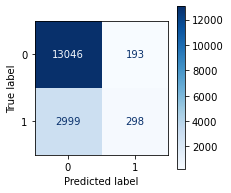

----------------------------------------------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89     13239
           1       0.61      0.09      0.16      3297

    accuracy                           0.81     16536
   macro avg       0.71      0.54      0.52     16536
weighted avg       0.77      0.81      0.74     16536



In [70]:
evaluate_model(pipeline, tags=["neighbourhood_min_count = 500", "booster=gbtree", "eta=0.2", "max_depth=6"])

### Uczenie nienadzorowane: autoencoder

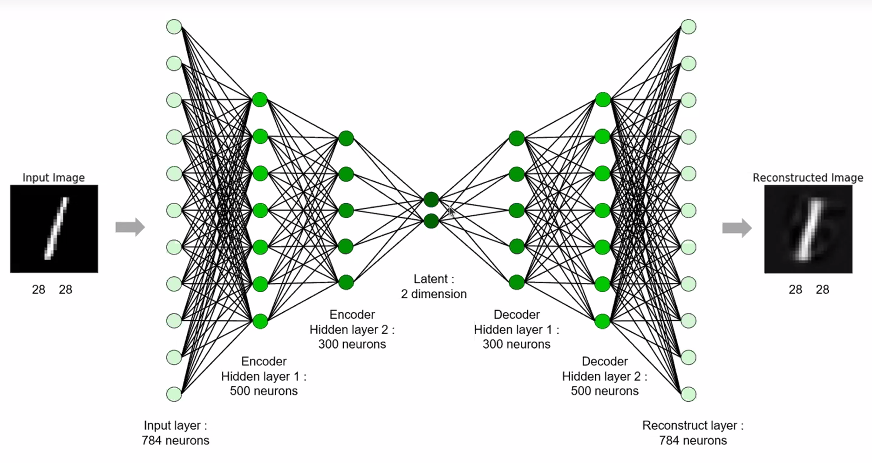

In [122]:
custom_transformer.fit(X_train, y_train)
X_train_transformed = custom_transformer.transform(X_train)
X_train_transformed.shape

(77212, 60)

In [123]:
X_valid_transformed = custom_transformer.transform(X_valid)

In [165]:
autoencoder = Sequential()

autoencoder.add(Dense(120, "relu", input_shape=(X_train_transformed.shape[1],)))
autoencoder.add(Dense(60, "relu")) 
autoencoder.add(Dense(2, "relu"))  # warstwa środkowa (znacznie mniej neuronów niż zmiennych)
autoencoder.add(Dense(60, "relu"))  
autoencoder.add(Dense(X_train_transformed.shape[1])) 
# ostatnia warstwa jest warstwą odtwarzającą X, bez funkcji aktywacji, bo ma zwrócić to, co sieć dostała

autoencoder.compile(optimizer="adam",  
                    loss="mean_squared_error",
                    metrics="mse")

early_stopping = EarlyStopping(monitor="val_loss", \
                               patience=3, \
                               restore_best_weights=True)

# Uwaga: trenujemy model tylko dla przypadków, gdy pacjent dotarł na wizytę (no-show = 0)
autoencoder.fit(X_train_transformed[y_train == 0], 
                y_train[y_train == 0], 
                batch_size = 32,
                validation_split=0.1, # zbiór walidacyjny na potrzeby EarlyStopping
                callbacks=[early_stopping], 
                epochs=200) # duża liczba epok, bo i tak chcemy zakończyć przez EarlyStopping

Epoch 1/200
1733/1733 [==============================] - 4s 2ms/step - loss: 4.3034e-06 - mse: 4.3034e-06 - val_loss: 3.0261e-27 - val_mse: 3.0261e-27
Epoch 2/200
1733/1733 [==============================] - 5s 3ms/step - loss: 2.1342e-14 - mse: 2.1342e-14 - val_loss: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 3/200
1733/1733 [==============================] - 3s 2ms/step - loss: 2.6933e-11 - mse: 2.6933e-11 - val_loss: 8.5989e-11 - val_mse: 8.5989e-11
Epoch 4/200
1733/1733 [==============================] - 8s 5ms/step - loss: 2.7037e-10 - mse: 2.7037e-10 - val_loss: 1.4306e-10 - val_mse: 1.4306e-10
Epoch 5/200
1733/1733 [==============================] - 7s 4ms/step - loss: 3.5798e-10 - mse: 3.5798e-10 - val_loss: 1.3390e-11 - val_mse: 1.3390e-11


In [166]:
# Wołamy predykcję dla zbioru walidacyjnego - chcemy porównać błędy rekonstrukcji
X_valid_predicted = autoencoder.predict(X_valid_transformed)

In [167]:
# Wyznaczamy średni błąd rekonstrukcji dla poszczególnych obserwacji
np.square(X_valid_transformed - X_valid_predicted).mean(1)

array([0.12675686, 0.09209913, 0.12853957, ..., 0.09342352, 0.15390698,
       0.05292185])

In [168]:
# Średni błąd rekonstrukcji dla całego zbioru walidacyjnego
np.square(X_valid_transformed - X_valid_predicted).mean(1).mean()

0.15437646422678697

In [169]:
# Średni błąd rekonstrukcji dla przypadków, gdy pacjent dotarł na wizytę (dla "no-show" = 0)
np.square(X_valid_transformed[y_valid == 0] - X_valid_predicted[y_valid == 0]).mean(1).mean()

0.14908208289007666

In [170]:
# Średni błąd rekonstrukcji dla przypadków, gdy pacjent nie dotarł na wizytę (dla "no-show" = 1)
np.square(X_valid_transformed[y_valid == 1] - X_valid_predicted[y_valid == 1]).mean(1).mean()

0.17563588628220345

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\neptune\internal\threads\ping_thread.py", line 37, in run
    self.__backend.ping_experiment(self.__experiment)
  File "C:\ProgramData\Anaconda3\lib\site-packages\neptune\internal\api_clients\hosted_api_clients\hosted_alpha_leaderboard_api_client.py", line 391, in ping_experiment
    self.leaderboard_swagger_client.api.ping(experimentId=str(experiment.internal_id)).response().result
  File "C:\ProgramData\Anaconda3\lib\site-packages\bravado\http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "C:\ProgramData\Anaconda3\lib\site-packages\six.py", line 703, in reraise
    raise value
  File "C:\ProgramData\Anaconda3\lib\site-packages\bravado\http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "C:\ProgramData\Anaconda3\lib\site-packages\bravado\http_future.py", line 124, in wrapper
    ret

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 272, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconnected: Remote end closed connection without response

During handling

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 670, in urlopen
    httplib_response = self._make_request(
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 426, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\ProgramData\Anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    httplib_response = conn.getresponse()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 1332, in getresponse
    response.begin()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "C:\ProgramData\Anaconda3\lib\http\client.py", line 264, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\ProgramData\Anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_int

In [163]:
# Należałoby przyjąć jakiś próg błędu i klasyfikować obserwację, jako "no-show", 
# jeśli bląd jest większy niż próg 

sbr = np.square(X_valid_transformed - X_valid_predicted).mean(1)

# Procent przypadków o błędzie > ..., które mają "no-show"==1
y_valid[sbr>0.17].mean() 


0.26529774127310063

## Final evaluation <a class="anchor" id="final"></a>

## Summary <a class="anchor" id="summary"></a>